<a href="https://colab.research.google.com/github/vasudev-sharma/Expand_AI_Interview/blob/master/Expand_ai_problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount the drive on Google Colab

In [1]:
# install weights and biases, and torchkeras library
!pip install wandb
!pip install torchkeras

In [1]:
# import libraries
import os
import math
import random
import shutil
from tqdm import tqdm 
from pathlib import Path
import wandb

# import scientific libraries
import numpy as np

# import pytorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets


In [ ]:
# set seed to reproduce results
np.random.seed(42)

In [2]:
# initialize wandb for logging
!wandb login

wandb: Currently logged in as: vs74 (use `wandb login --relogin` to force relogin)


In [3]:
# mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# path of data
data_path = '/content/drive/MyDrive/data/diseases_copy4'
CLASSES = ["COVID", "NORMAL", "PNEUMONIA"]


DATASET PREPARATION

In [2]:
# prepare the dataset into train, test set
# TODO: Look how to split the data into train 
list_images = os.listdir(data_path)
len_data = len(list_images)
print(len_data)



train_split = 0.8
test_split = 1 - train_split

# size of train and test data
train_data_len = math.ceil(train_split * len_data)
test_data_len = math.ceil(test_split * len_data)

print(f'Size of the train data and test data are {train_data_len} and {test_data_len} respectively')

train_list_images = random.sample(list_images, train_data_len)
test_list_images = list( set(list_images) - set(train_list_images))

assert len(train_list_images) == train_data_len
assert len(test_list_images) == test_data_len

NameError: ignored

In [71]:
# make train and test directories
try: 
  os.mkdir(os.path.join(data_path, 'train')) # train directory
except Exception as e:
  print('Train directory already exists')


try:
  os.mkdir(os.path.join(data_path, 'test')) # test directory
except Exception as e:
  print('Test directory already exists')

assert os.path.exists(os.path.join(data_path, 'train')) == True
assert os.path.exists(os.path.join(data_path, 'test')) == True

In [72]:
# Helper function to split the images into Train and Validation set

def split_images(list_images, dir_name):

  for image in tqdm(list_images):

    # iterate through all the classes
    for class_index in range(len(CLASSES)):
      # COVID class
      if image.startswith(CLASSES[class_index]): 
        try:
          os.mkdir(os.path.join(data_path, dir_name, CLASSES[class_index]))
        except Exception as e:
          pass

        shutil.move(os.path.join(data_path, image), os.path.join(data_path, dir_name, CLASSES[class_index], image))

  print(f'Preprocessing of {dir_name} dataset is completed')


In [73]:
# Preprocess the train and test set
split_images(train_list_images, 'train') # preprocessing for the train_dataset


100%|██████████| 720/720 [00:02<00:00, 283.20it/s]

Preprocessing of train dataset is completed


In [74]:
split_images(test_list_images, 'test') # preprocessing for the train_dataset


100%|██████████| 180/180 [00:00<00:00, 299.05it/s]

Preprocessing of test dataset is completed


DATASETS AND DATALOADERS

In [240]:
train_data_path = Path(data_path) / 'train'
test_data_path = Path(data_path) / 'test'

print(f'Train and test data paths are {train_data_path} and {test_data_path} respectively')

Train and test data paths are /content/drive/MyDrive/data/diseases_copy4/train and /content/drive/MyDrive/data/diseases_copy4/test respectively


In [241]:
# transforms
train_transform = transforms.Compose(
    [
     transforms.Resize(256),
     transforms.RandomCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)
test_transform = transforms.Compose(
    [
     transforms.Resize(256),
     transforms.RandomCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [242]:
# datasets

ds_train = datasets.ImageFolder(str(train_data_path), transform = train_transform, target_transform = lambda t:torch.tensor(t).long())
ds_test = datasets.ImageFolder(str(test_data_path), transform = test_transform, target_transform = lambda t: torch.tensor(t).long())

In [243]:
# Class labels
print(ds_train.class_to_idx)

{'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [244]:
# set hyperparameters
batch_size = 16
lr = 5e-5
epochs = 30
log_freq = 10

num_classes = len(CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cuda')



In [245]:
# dataloaders
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


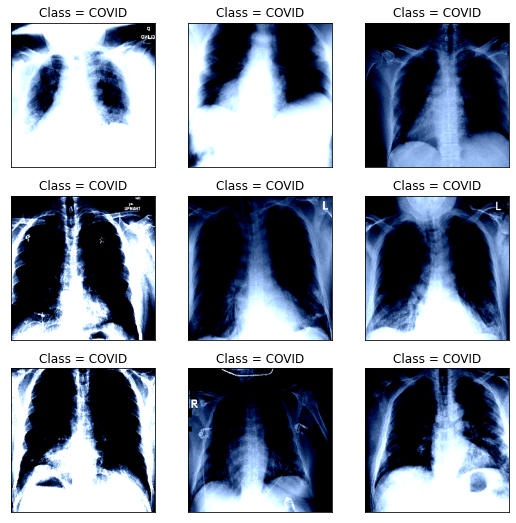

In [246]:
%matplotlib inline

# plot the images
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 9))
# plot 9 images
for i in range(9):
  image, label = ds_train[i]
  img = image.permute(1, 2, 0)
  ax = plt.subplot(3, 3, i + 1)
  ax.imshow(img.numpy())
  ax.set_title('Class = %s' % CLASSES[int(label.item())])
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

In [247]:
# load a pretrained Densenet 121 model for finetuing on the Chest X_ray images
model = torch.hub.load('pytorch/vision:v0.9.0', 'densenet121', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [248]:
model.classifier = nn.Linear(1024, num_classes)

In [249]:
# Move the model to CUDA, if available
if torch.cuda.is_available():
  model.to(device)

In [250]:
from torchkeras import summary
# check the summary of the model 

# summary(model, (3, 256, 256))

In [251]:
# This code is taken from https://stackoverflow.com/questions/62265351/measuring-f1-score-for-multiclass-classification-natively-in-pytorch

from typing import Tuple
# Macro F1 score PyTorch

class F1Score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    @staticmethod
    def calc_f1_count_for_label(predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self.calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, len(labels.unique()) + 1):
            f1, true_count = self.calc_f1_count_for_label(predictions, labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score

In [252]:
# Define optimizer, loss, macro and micro F1 scores

model.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model.optimizer, T_max = 5)
model.loss_func = torch.nn.CrossEntropyLoss()
model.macro_f1_score = F1Score(average='macro')
model.micro_f1_score = F1Score(average='micro')

In [253]:
# sanity check the dataloader: logits and labels
for batch in dl_train:
  logits, labels = batch 
  logits, labels = logits.to(device), labels.to(device)
  print(logits.shape)
  print(labels.shape)
  break

torch.Size([16, 3, 224, 224])
torch.Size([16])


In [254]:
def train_step(model, features, labels):
  # training
  model.train() 

  model.optimizer.zero_grad()

  logits = model(features)
  loss = model.loss_func(logits, labels)


  # compute the accuracy 
  probs = torch.softmax(logits, dim=1)
  predicted_labels = torch.argmax(logits, dim = 1)

  correct = predicted_labels == labels
  accuracy = correct.sum().float() / float(labels.size(0))

  # F1 metrics
  
  # macro F1 score
  macro_f1_score = model.macro_f1_score(predicted_labels.flatten(), labels.flatten())

  # micro F1 score
  micro_f1_score = model.micro_f1_score(predicted_labels.flatten(), labels.flatten())


  # Backwardprop
  loss.backward()
  model.optimizer.step()
  model.scheduler.step()

  return loss.item(), accuracy, macro_f1_score.item(), micro_f1_score.item()


In [255]:
def valid_step(model, features, labels):
  # validation
  model.eval()

  with torch.no_grad():
    logits = model(features)
    loss = model.loss_func(logits, labels)
    
    # compute the accuracy 
    probs = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim = 1)

    correct = predicted_labels == labels
    accuracy = correct.sum().float() / float(labels.size(0))


    # F1 metrics
    
    # macro F1 score
    macro_f1_score = model.macro_f1_score(predicted_labels.flatten(), labels.flatten())

    # micro F1 score
    micro_f1_score = model.micro_f1_score(predicted_labels.flatten(), labels.flatten())

  

  return loss.item(), accuracy, macro_f1_score.item(), micro_f1_score.item()


In [256]:
def train_model(model, dl_train, dl_test, epochs, log_freq):
  print('********Training has started***************')


  wandb.watch(model, log='all')


  for epoch in range(1, epochs + 1):
    
    # trainining
    loss_sum = 0.0
    accuracy_sum = 0.0 
    macro_f1_score_sum = 0
    micro_f1_score_sum = 0
    step = 1


    for step, (features, labels) in enumerate(dl_train, 1):
      
      # Migrate the inputs, labels to device
      features, labels = features.to(device), labels.to(device)

      # training step
      loss, accuracy, macro_f1_score, micro_f1_score = train_step(model, features, labels)
     
      # training metrics
      loss_sum+= loss
      accuracy_sum+= accuracy
      macro_f1_score_sum+= macro_f1_score
      micro_f1_score_sum+= micro_f1_score
      
      if step % log_freq == 0:
        print('->[step = % d] loss = %.3f, accuracy = %.3f, macro_F1_score = %.3f, micro_F1_score = %.3f' % 
              (step, loss_sum / step, accuracy_sum / step, macro_f1_score_sum / step, micro_f1_score_sum / step))
  
    # validation 
    val_loss_sum = 0.0
    val_accuracy_sum = 0.0
    val_macro_f1_score_sum = 0
    val_micro_f1_score_sum = 0
    val_step = 1

    for val_step, (features, labels) in enumerate(dl_test, 1):

      # Migrate the inputs, labels to device
      features, labels = features.to(device), labels.to(device)

      # validation step
      val_loss, val_accuracy,  val_macro_f1_score, val_micro_f1_score = valid_step(model, features, labels)

      # validation metrics
      val_loss_sum+= val_loss
      val_accuracy_sum+= val_accuracy
      val_macro_f1_score_sum+= val_macro_f1_score
      val_micro_f1_score_sum+= val_micro_f1_score

    print('\n[Epoch = %d]: loss = %.3f, accuracy = %.3f, val_loss = %.3f, val_accuracy = %.3f, val_macro_F1_score = %.3f, val_micro_F1_score = %.3f' %
          (epoch, loss_sum / step, accuracy_sum / step, val_loss_sum / val_step, val_accuracy_sum / val_step, val_macro_f1_score_sum / val_step, val_micro_f1_score_sum / val_step))
    print("\n"+"=========="*8)


    wandb.log({
        'epoch': epoch,
        'training_loss': loss_sum / step,
        'training_accuracy': accuracy_sum / step,
        'train_macro_f1_score': macro_f1_score_sum / step,
        'train_micro_f1_score': micro_f1_score_sum / step,
        'validation_loss': val_loss_sum / val_step,
        'validation_accuracy': val_accuracy_sum / val_step,
        'val_macro_f1_score': val_macro_f1_score_sum / val_step,
        'val_micro_f1_score': val_micro_f1_score_sum / val_step,
    })
  
  print('**************Fine tuning has Finished**********************')
  
  # saving the model
  torch.save(model.state_dict(), 'model.h5')
  wandb.save('model.h5')


In [257]:
def main():
  # wandb initialize a new run
  wandb.init(project='Expand-ai-problem-1')
  wandb.watch_called = False

  config = wandb.config
  config.batch_size = batch_size
  config.epochs = epochs
  config.lr = lr
  config.seed = 42
  config.classes = len(CLASSES)
  config.device = device

  # set seed
  torch.manual_seed(config.seed)
  torch.backends.cudnn.deterministic = True

  train_model(model, dl_train, dl_test, epochs, log_freq)

if __name__=='__main__':
  main()
  wandb.finish()


********Training has started***************
->[step =  10] loss = 0.970, accuracy = 0.550, macro_F1_score = 0.228, micro_F1_score = 0.550
->[step =  20] loss = 0.901, accuracy = 0.584, macro_F1_score = 0.269, micro_F1_score = 0.584
->[step =  30] loss = 0.810, accuracy = 0.665, macro_F1_score = 0.346, micro_F1_score = 0.665
->[step =  40] loss = 0.733, accuracy = 0.723, macro_F1_score = 0.407, micro_F1_score = 0.723

[Epoch = 1]: loss = 0.698, accuracy = 0.742, val_loss = 0.368, val_accuracy = 0.964, val_macro_F1_score = 0.632, val_micro_F1_score = 0.964

->[step =  10] loss = 0.405, accuracy = 0.875, macro_F1_score = 0.547, micro_F1_score = 0.875
->[step =  20] loss = 0.350, accuracy = 0.906, macro_F1_score = 0.574, micro_F1_score = 0.906
->[step =  30] loss = 0.315, accuracy = 0.927, macro_F1_score = 0.595, micro_F1_score = 0.927
->[step =  40] loss = 0.300, accuracy = 0.928, macro_F1_score = 0.597, micro_F1_score = 0.928

[Epoch = 2]: loss = 0.289, accuracy = 0.932, val_loss = 0.181

epoch,30
training_loss,0.01317
training_accuracy,0.99722
train_macro_f1_score,0.66334
train_micro_f1_score,0.99722
validation_loss,0.07892
validation_accuracy,0.98438
val_macro_f1_score,0.59401
val_micro_f1_score,0.98438
_runtime,388
_timestamp,1623067194


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_loss,█▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,▁▆▇▇▇▇▇███████████████████████
train_macro_f1_score,▁▆▇▇▇▇▇███████████████████████
train_micro_f1_score,▁▆▇▇▇▇▇███████████████████████
validation_loss,█▄▃▃▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▂
validation_accuracy,▄▂▄▁▇▇▇▆▅▆▇▆█▄▆▇▇▇█▄▄▇▄▇▇▄▇▇█▇
val_macro_f1_score,▅▄▇▁▆▇▅▅▆▅▅▅▇▄▅▆█▅▇▄▅▅▇▅▅▅▆▆▇▂
val_micro_f1_score,▄▂▅▁▇▇▇▆▅▆▇▆█▅▆▇▇▇█▅▄▇▅▇▇▅▇▇█▇
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


In [65]:
array_1 = np.zeros((3,5, 6))
array_2 = np.ones((3,5,6))

In [66]:
f1_score(array_1, array_2, average='macro')

ValueError: ignored

In [64]:
array_1.ndim

3